In [1]:
# Imports
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from time import time

from skimage.io import imread
from skimage.color import rgb2gray
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import torchvision.datasets as datasets
import skimage.io as io
from skimage.transform import resize
import natsort
from natsort import natsorted
from numpy import asarray
from tqdm.notebook import tqdm


In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [13]:
from google.colab import drive
# This will prompt for authorization.

drive.mount('/content/drive/')
!ls '/content/drive/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
MyDrive


In [31]:
# import our helper functions needed in the notebook.
import sys
drive_path = '/content/drive/MyDrive/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/detection'
sys.path.insert(0, drive_path)
import project_utils
from project_utils import *

In [ ]:
trainpath = '/content/drive/MyDrive/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/train' # there are a total of 330 images in the train file

X, Y = get_data(path=trainpath, start=0, end=80, size=(256,256))

['train_1.bmp', 'train_2.bmp', 'train_3.bmp', 'train_4.bmp', 'train_6.bmp', 'train_7.bmp', 'train_8.bmp', 'train_9.bmp', 'train_10.bmp', 'train_12.bmp', 'train_13.bmp', 'train_14.bmp', 'train_15.bmp', 'train_17.bmp', 'train_18.bmp', 'train_19.bmp', 'train_20.bmp', 'train_21.bmp', 'train_22.bmp', 'train_23.bmp', 'train_24.bmp', 'train_25.bmp', 'train_26.bmp', 'train_27.bmp', 'train_28.bmp', 'train_29.bmp', 'train_30.bmp', 'train_31.bmp', 'train_32.bmp', 'train_33.bmp', 'train_34.bmp', 'train_35.bmp', 'train_36.bmp', 'train_38.bmp', 'train_39.bmp', 'train_40.bmp', 'train_41.bmp', 'train_42.bmp', 'train_43.bmp', 'train_44.bmp', 'train_45.bmp', 'train_46.bmp', 'train_47.bmp', 'train_48.bmp', 'train_49.bmp', 'train_50.bmp', 'train_51.bmp', 'train_52.bmp', 'train_53.bmp', 'train_54.bmp', 'train_55.bmp', 'train_56.bmp', 'train_58.bmp', 'train_59.bmp', 'train_60.bmp', 'train_61.bmp', 'train_62.bmp', 'train_63.bmp', 'train_64.bmp', 'train_65.bmp', 'train_66.bmp', 'train_67.bmp', 'train_68.bmp',

In [ ]:
nr = 1
X_ex = np.moveaxis(X[nr], 0, -1)
Y_ex = Y[nr]
print(X_ex.shape)
print(Y_ex.shape)

(256, 256, 3)
(256, 256)


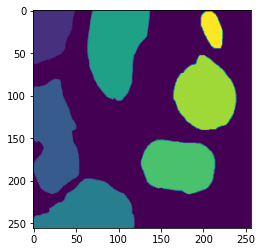

In [ ]:
# Veiw some images
nr = 0
# plt.imshow(X[nr])
plt.imshow(Y[nr])

In [ ]:
#@title
# mask = io.imread('/content/sample_data/testA_9_anno.bmp')
# mask = np.array(mask)
# obj_ids = np.unique(mask)
# # first id is the background, so remove it
# obj_ids = obj_ids[1:]

# # split the color-encoded mask into a set
# # of binary masks
# masks = mask == obj_ids[:, None, None]

# # get bounding box coordinates for each mask
# num_objs = len(obj_ids)
# boxes = []
# for i in range(num_objs):
#     pos = np.where(masks[i])
#     xmin = np.min(pos[1])
#     xmax = np.max(pos[1])
#     ymin = np.min(pos[0])
#     ymax = np.max(pos[0])
#     boxes.append([xmin, ymin, xmax, ymax])

# len(boxes)

14

In [ ]:
#@title
# import matplotlib.patches as mpatches

# fig, ax = plt.subplots(figsize=(10, 6))
# ax.imshow(mask)

# for i in boxes:
#     # take regions with large enough areas
#     # if region.area >= 10:
#     # draw rectangle around segmented coins
#     xmin, ymin, xmax, ymax = i
#     rect = mpatches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
#                               fill=False, edgecolor='red', linewidth=2)
#     ax.add_patch(rect)

# ax.set_axis_off()
# plt.tight_layout()
# plt.show()

In [ ]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
""" Full assembly of the parts to form the complete network """

import torch.nn.functional as F

# from .unet_parts import *


class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
#@title
# a = torch.arange(0, 4).unsqueeze(0).unsqueeze(2).expand(2, -1, 4, 3)
# b = torch.arange(3, 6).unsqueeze(0).unsqueeze(2).expand(2, -1, 4)
# a = torch.empty(10, 1, 5, 5)
# b = torch.ones(10, 5, 5)
# print(a.shape, b.shape)
# b = b.unsqueeze(1)
# # b = torch.cat([a, b], dim=1)
# print(b[1])
# b[1] = a[1]
# print('a[1]:', a[1])
# print(b[1])
# print('new size b:', b.shape)

In [ ]:
def focal_loss(y_pred, y_real, gamma=2):
    y_pred = torch.clamp(F.sigmoid(y_pred), 1e-8, 1-1e-8)
    # gamma = 2
    return -torch.mean(((1-y_pred)**gamma)*y_real*torch.log(y_pred) + (1-y_real)*torch.log(1-y_pred))

In [ ]:
batch_size = 4
dataloader2 = DataLoader(list(zip(X, Y)), batch_size=batch_size, shuffle=True)

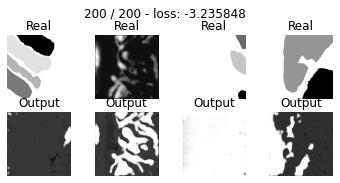

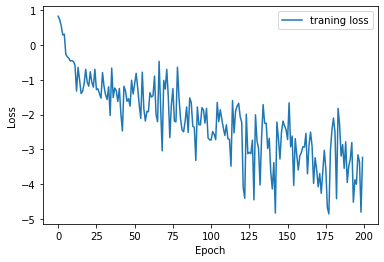

In [ ]:
# Predefine input size 
n_channels = 3
n_classes = 2
# Next creat an instance of the UNet model
modelUnet = UNet().to(device)

criterion = torch.nn.BCEWithLogitsLoss()

# Now define the optimizer
optimizerUnet = optim.Adam(modelUnet.parameters(), lr = 0.00001, weight_decay=0)

# And finally lets train the model
# train(modelUnet, optimizerUnet, focal_loss, 500, dataloader2, print_status=True)
model_out = train(modelUnet, optimizerUnet, criterion, 200, dataloader2, print_status=True)

In [ ]:
X_batch, Y_batch = next(iter(dataloader2))
# X = X[0].to(device)
# X = Variable(torch.from_numpy(X[0]))
model_out.eval()  # testing mode
Y_hat = F.sigmoid(model_out(X_batch.to(device))).detach().cpu()
# Y_batch[5:] = 0
# Y_hat[5:] = 0

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


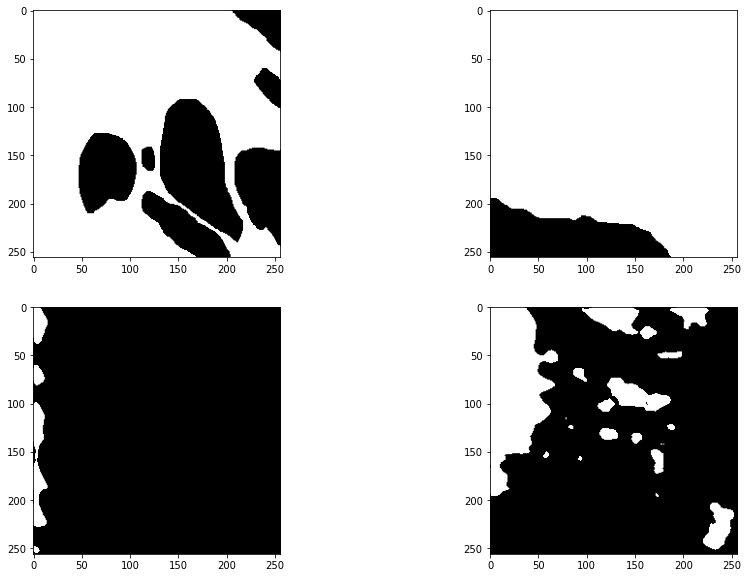

In [ ]:
# 0=white, 1=black

view_mask(targets=Y_batch, output=Y_hat, n=2)

In [ ]:
testpath = '/content/drive/MyDrive/warwick_qu_dataset_released_2016_07_08/Warwick QU Dataset (Released 2016_07_08)/test' # there are a total of 330 images in the train file

X, Y = get_data(path=testpath, start=0, end=70, size=(256,256))
batch_size = 2
dataloader_test = DataLoader(list(zip(X, Y)), batch_size=batch_size, shuffle=False)

['testA_1.bmp', 'testA_2.bmp', 'testA_3.bmp', 'testA_4.bmp', 'testA_5 (1).bmp', 'testA_5.bmp', 'testA_6.bmp', 'testA_7.bmp', 'testA_9.bmp', 'testA_10.bmp', 'testA_11.bmp', 'testA_13.bmp', 'testA_14.bmp', 'testA_15.bmp', 'testA_16.bmp', 'testA_17.bmp', 'testA_18.bmp', 'testA_19.bmp', 'testA_20.bmp', 'testA_21.bmp', 'testA_22.bmp', 'testA_23.bmp', 'testA_24.bmp', 'testA_25.bmp', 'testA_26.bmp', 'testA_27.bmp', 'testA_28.bmp', 'testA_29.bmp', 'testA_30.bmp', 'testA_31.bmp', 'testA_32.bmp', 'testA_33.bmp', 'testA_35.bmp', 'testA_36.bmp', 'testA_37.bmp', 'testA_38.bmp', 'testA_39.bmp', 'testA_40.bmp', 'testA_41.bmp', 'testA_42.bmp', 'testA_43.bmp', 'testA_44.bmp', 'testA_45.bmp', 'testA_46.bmp', 'testA_47.bmp', 'testA_49.bmp', 'testA_50.bmp', 'testA_51.bmp', 'testA_52.bmp', 'testA_53.bmp', 'testA_54.bmp', 'testA_55.bmp', 'testA_58.bmp', 'testA_60.bmp', 'testB_1.bmp', 'testB_2.bmp', 'testB_3.bmp', 'testB_4.bmp', 'testB_5.bmp', 'testB_6.bmp', 'testB_7.bmp', 'testB_8.bmp', 'testB_10.bmp', 'tes

In [ ]:
# Get IoU scores for test set

IoU_scores_list = []
dice_coef_scores_list = []
f1_scores_list = []
skipped = 0
for X_batch, Y_batch in tqdm(dataloader_test): # dataloader2
  model_out.eval()  # testing mode
  Y_hat = F.sigmoid(model_out(X_batch.to(device))).detach().cpu()
  # print(len(Y_hat))
  # print(len(Y_batch))
  for i in range(len(Y_batch)):
    # target (true) masks
    target_im = Y_batch[i].cpu().detach().numpy()
    target_im[target_im>0.5] = 1
    target_im[target_im<0.5] = 0
    target_im = target_im.astype('int64')
    # output (predicted) masks
    output_im = Y_hat[i][0, :, :].cpu().detach().numpy()
    output_im[output_im>0.485] = 1
    output_im[output_im<0.485] = 0
    output_im = output_im.astype('int64')

    if target_im.shape != output_im.shape:
      skipped+=1
      continue

    # print(np.unique(target_im))
    # print(np.unique(output_im))
    # target_im_list = target_im.tolist()
    # output_im_list = output_im.tolist()
    f1_score = get_f1_score(target_im, output_im)
    f1_scores_list.append(f1_score)

    dice_coef_score = dice_coef(y_real=target_im, y_pred=output_im)
    dice_coef_scores_list.append(dice_coef_score)
    IoU_score = IoU(y_real=target_im, y_pred=output_im) 
    IoU_scores_list.append(IoU_score)

print('mean IoU score for test set:', np.mean(IoU_scores_list))
print('mean Dice Coefficient score for test set:', np.mean(dice_coef_scores_list)) # Not sure of correct
print('f1 score for test set:', np.mean(f1_scores_list))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



mean IoU score for test set: 0.31181829048528614
mean Dice Coefficient score for test set: 0.840566907610212
f1 score for test set: 0.8482238262196622


In [ ]:
skipped

0